# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


In [369]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mnso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import the dataset:

In [370]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data Validation:
The original dataset has **947 rows and 8 columns**. After validating the data on each column, I made some changes as below.
- **Recipe**: 947 unique values without missing values, similar to the description. After data cleaning, 52 rows were removed because of the missing values from other columns.
- **Calorie**s: 895 non-null values, similar to the description. 52 missing values were replaced by the average value of the "calories" column grouped by "category" and "servings".
- **Carbohydrate**: 895 non-null values, similar to the description. 52 missing values were replaced by the average value of the "carbohydrate" column grouped by "category" and "servings".
- **Sugar**: 895 non-null values, similar to the description. 52 missing values were replaced by the average value of the "sugar" column grouped by "category" and "servings".
- **Protein**: 895 non-null values, similar to the description. 52 missing values were replaced by the average value of the "protein" column grouped by "category" and "servings".
- **Category**: 11 unique categories without missing values instead of 10 categories provided by the description. I merged category _"Chicken Breast"_ into category _"Chicken"_ because they belong to the same category.
- **Servings**: 6 unique categories without missing values. According to the description, "servings" must be a numeric column, not a character column. Two extra categories _"4 as a snack"_ and _"6 as a snack"_ were merged into _"4"_ and _"6"_, respectively. The column type was changed to integer.
- **High-traffic**: 1 non-null values, similar to the description. 373 missing values were replaced with _"Low"_.

# Data Cleaning:
- Remove rows with null values in **calories, carbohydrate, sugar, protein** to maintain data integrity.
- **Category**: _"Chicken Breast"_ category was united with the _"Chicken"_ category to ensure consistency.
- **Servings**: Extra values _"4 as a snack"_ and _"6 as a snack"_ were united with _"4"_ and _"6"_, respectively, and the column type was changed to integer.
- **High-traffic**: Replace null values with _"Low"_.

Furthermore, I created four more columns that illustate the total nutrients of each recipe.
After validating and cleaning, the dataset has **895 rows and 11 columns**.

## Overview the dataset:

In [371]:
# Check size of dataset
df.shape
print("The dataset has {} rows and {} columns.".format(df.shape[0],df.shape[1]))

The dataset has 947 rows and 8 columns.


The dataset has 947 rows and 8 columns.

In [372]:
# Overview the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


- The dataset has 8 columns: recipe, calories, carbohydrate, sugar, protein, category, servings, and high_traffic.
- Numerical columns: recipe, calories, carbohydrate, sugar, protein.
- Categorical columns: category, servings, high_traffic.

In [373]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [374]:
# Number of missing values in each columns
df.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

Column calories, carbohydrate, sugar, protein and high_traffic have missing values.

## Categorical columns:

In [375]:
# Number of unique value of categorical columns
num_unique_objects = df.select_dtypes(include='object').nunique()
unique_values = df.select_dtypes(include='object').apply(lambda x: x.unique())
num_unique_objects,unique_values

(category        11
 servings         6
 high_traffic     1
 dtype: int64,
 category        [Pork, Potato, Breakfast, Beverages, One Dish ...
 servings                 [6, 4, 1, 2, 4 as a snack, 6 as a snack]
 high_traffic                                          [High, nan]
 dtype: object)

- Category has 11 unique categories instead of 10 according to the description.
- Servings has 6 unique categories and has inconsistent data.
- High_traffic has 1 unique categories and has missing values.

### Column Category:

In [376]:
# Count values in column category
df.category.value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

According to the description, there are only 10 categories. But in the original dataset, the extra category _"Chicken Breast"_ was also recorded. Therefore, I will merge it with category _"Chicken"_.

In [377]:
# Merge category Chicken Breast into Chicken
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')

### Column Servings:

In [378]:
# Count values in servings category
df.servings.value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

- For column servings, they used to have inconsistent data. Therefore, I changed _"4 as a snack"_ and "6 as a snack" into _"4"_ and _"6"_, respectively.
- I also changed the servings column to numeric type.

In [379]:
# Get numeric character
df['servings'] = df['servings'].str.extract(r'(\d+)')

# Change servings column to integer type
df['servings'] = df['servings'].astype('int')

### Column High_traffic:

In [380]:
# Count values in column high traffic (include null values)
df['high_traffic'].value_counts(dropna=False)

High    574
NaN     373
Name: high_traffic, dtype: int64

For column high_traffic, 373 missing values are understood as Low traffic. Therefore, I replaced missing values with _"Low"_.

In [381]:
# Replace missing values with "Low"
df['high_traffic'] = df['high_traffic'].fillna("Low")

## Numerical columns:

Number of missing values in the dataset

In [382]:
# Number of missing values
df.isnull().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

Now, we have 52 missing values in calories, carbohydrate, sugar, protein.

<AxesSubplot: >

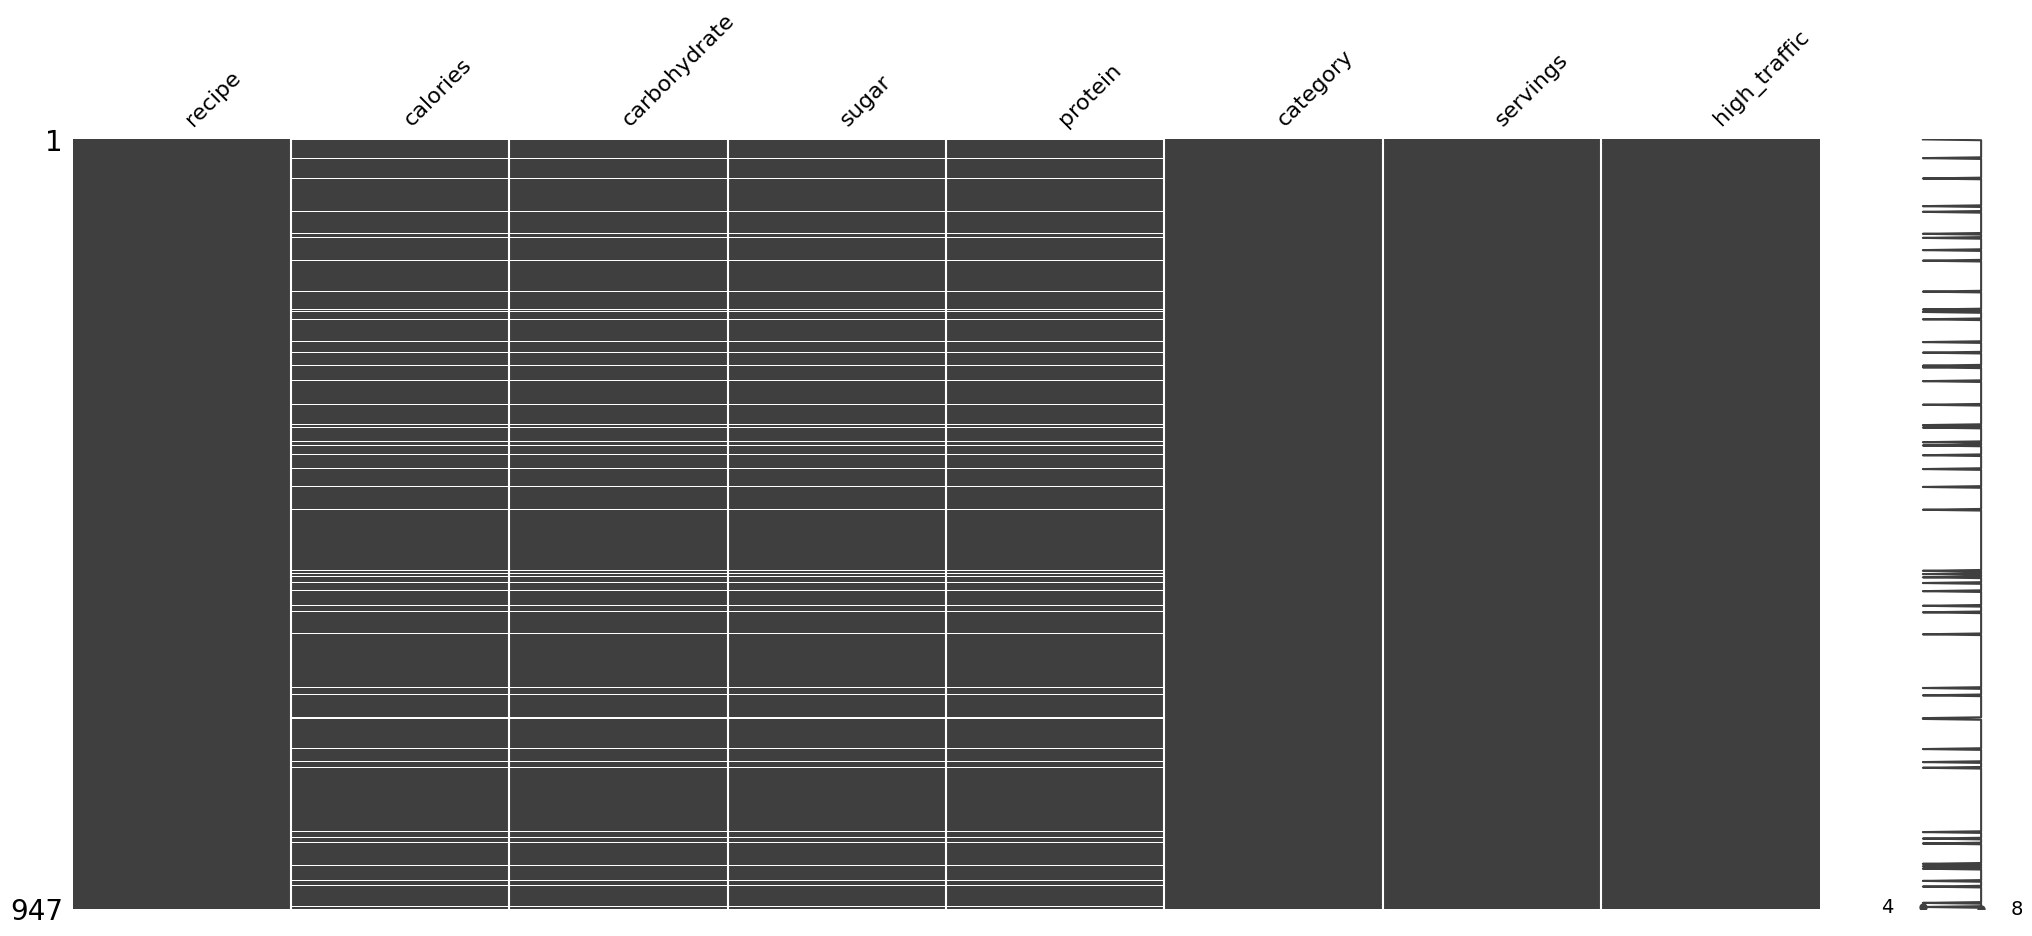

In [383]:
# Show the distributions of missing values in the dataset
mnso.matrix(df)

<AxesSubplot: >

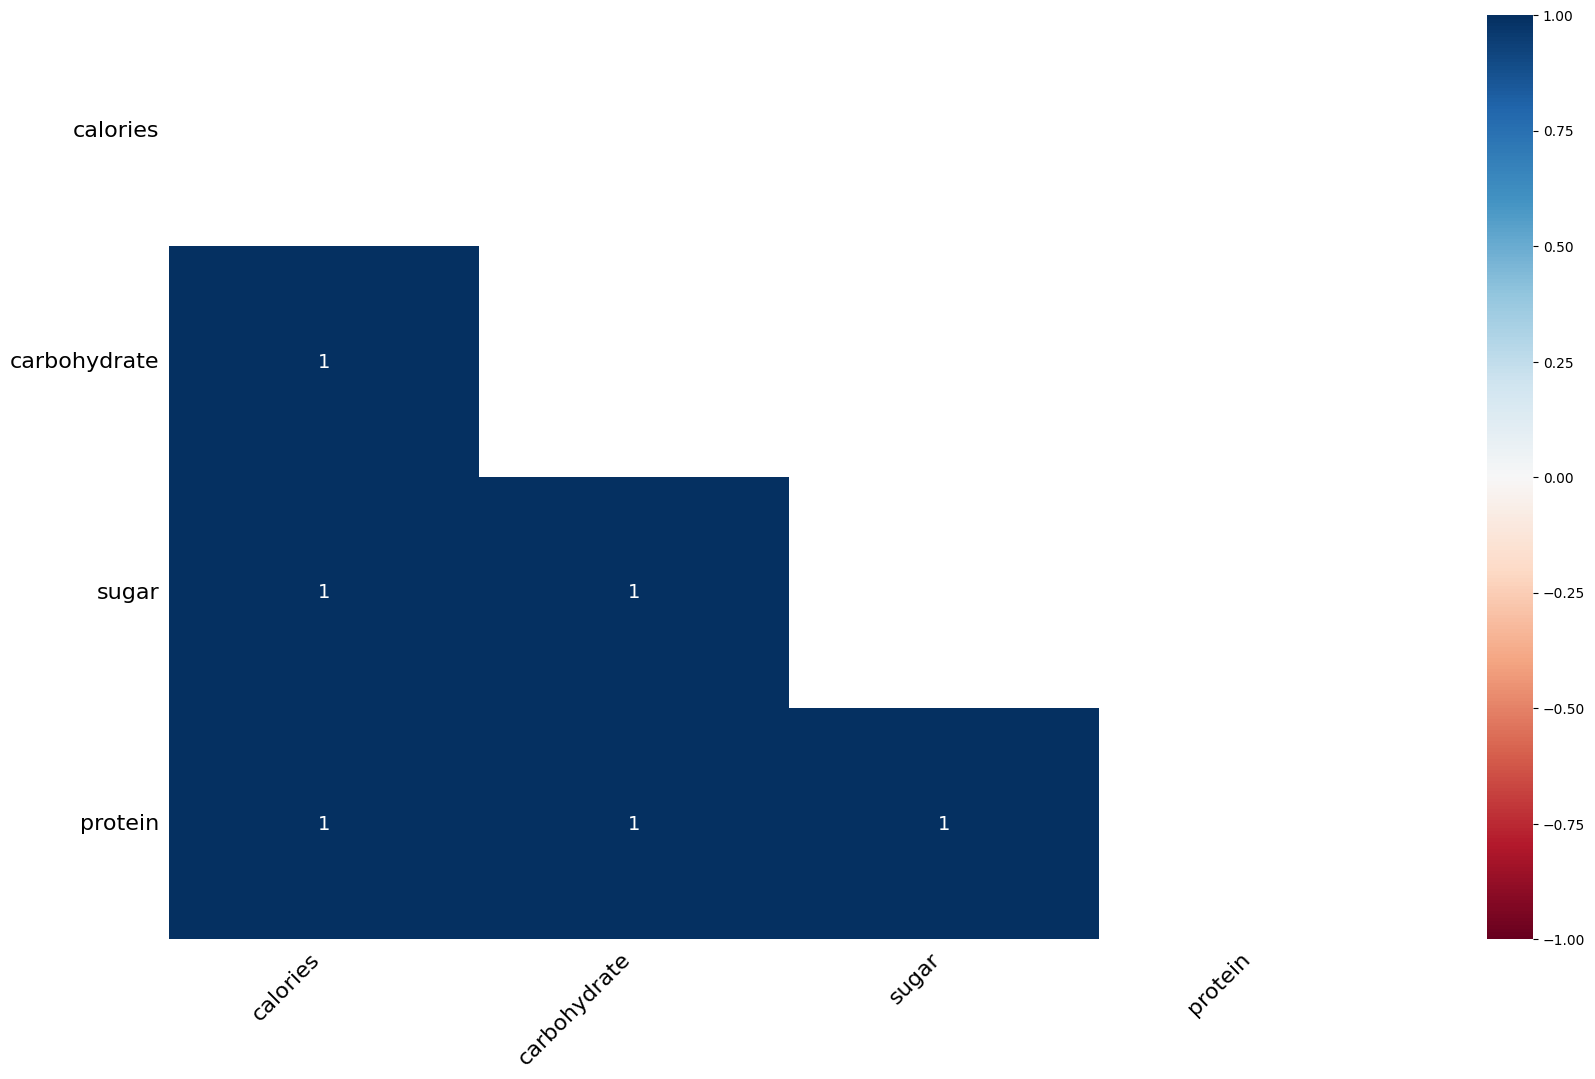

In [384]:
mnso.heatmap(df)

In [385]:
# Rows have missing values
missing_values = df[df.isnull().any(axis=1)]
missing_values

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,Low
48,49,NaN,NaN,NaN,NaN,Chicken,4,Low
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
116,117,NaN,NaN,NaN,NaN,Chicken,6,High
121,122,NaN,NaN,NaN,NaN,Dessert,2,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,150,NaN,NaN,NaN,NaN,Potato,2,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High


In [386]:
# Calculate percent of missing values
percent_missing = (missing_values.isnull().sum() / len(df)) * 100
percent_missing

recipe          0.000000
calories        5.491024
carbohydrate    5.491024
sugar           5.491024
protein         5.491024
category        0.000000
servings        0.000000
high_traffic    0.000000
dtype: float64

We can see that all the remaining missing data from these columns (calories, carbohydrate, sugar, protein) are on the same row. These rows also account for 5.5% of the dataset.
Therefore, I will remove these rows to ensure the data integrity.

In [387]:
# Remove rows have missing values
df.dropna(axis=0,inplace=True)
df.shape

(895, 8)

In case I want to impute the missing values, I will fill them with mean of column value group by category and servings.

In [388]:
# Impute missing values
nutrient = ['calories','carbohydrate','sugar','protein']
for col in nutrient:
    df[col] = df[col].fillna(df.groupby(['category','servings'])[col].transform('mean'))

## Further data cleaning steps:
### Remove column Recipe:
I will drop column **recipe** because it just the ID of the recipe and won't help us with further analysis.

In [389]:
# Remove column Recipe
df.drop('recipe',axis=1,inplace=True)

### Check negative number and duplicated values:

In [390]:
df.describe()

,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296,3.458101
std,453.020997,43.949032,14.679176,36.369739,1.735979
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,110.430000,8.375000,1.690000,3.195000,2.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000
75%,597.650000,44.965000,9.800000,30.200000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


The dataset doesn't have any negative values.

In [391]:
# Check number of duplicate values
num_duplicates = df.duplicated().sum()
num_duplicates

0

Good news !!! The dataset doesn't have any duplicate values.

### Add more columns for data visualization:
According to the description, all the nutrients of each recipe were calculated per serving. Therefore, I created four more columns to illustrate the total amount of each recipe.

In [392]:
for col in nutrient:
    df['total_'+col] = df[col] * df['servings']

The dataset after data validation and data cleaning.

In [393]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic,total_calories,total_carbohydrate,total_sugar,total_protein
1,35.48,38.56,0.66,0.92,Potato,4,High,141.92,154.24,2.64,3.68
2,914.28,42.68,3.09,2.88,Breakfast,1,Low,914.28,42.68,3.09,2.88
3,97.03,30.56,38.63,0.02,Beverages,4,High,388.12,122.24,154.52,0.08
4,27.05,1.85,0.80,0.53,Beverages,4,Low,108.20,7.40,3.20,2.12
5,691.15,3.46,1.65,53.93,One Dish Meal,2,High,1382.30,6.92,3.30,107.86


In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   calories            895 non-null    float64
 1   carbohydrate        895 non-null    float64
 2   sugar               895 non-null    float64
 3   protein             895 non-null    float64
 4   category            895 non-null    object 
 5   servings            895 non-null    int64  
 6   high_traffic        895 non-null    object 
 7   total_calories      895 non-null    float64
 8   total_carbohydrate  895 non-null    float64
 9   total_sugar         895 non-null    float64
 10  total_protein       895 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 83.9+ KB


# Exploratory Analysis:
The product manager wants us to predict the high traffic recipe. Therefore, I choose **high_traffic** column as the target variable.
## Target variable: High traffic

Text(0.5, 0, 'Traffic Status')

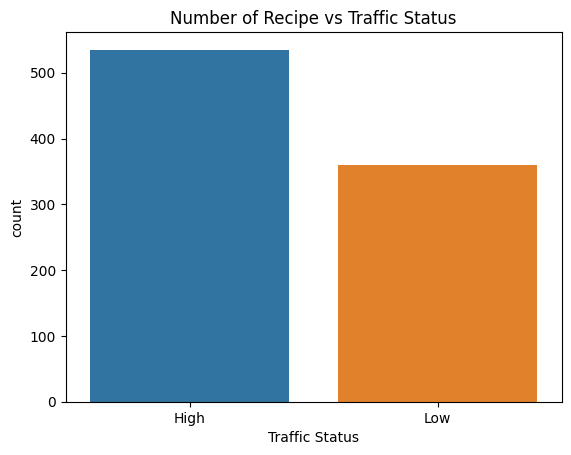

In [395]:
# Count plot for high traffic
sns.countplot(data=df,x='high_traffic')
plt.title('Number of Recipe vs Traffic Status')
plt.xlabel("Traffic Status")

In [396]:
# Calculate number of high, low traffic recipes and their percentage, respectively
high, low = df['high_traffic'].value_counts()

print('Number of recipe labeled as high:',high,'recipes and it accounts for {}%.'.format(round(high/len(df)*100,2)))
print('Number of recipe labeled as low:',low,'recipes and it accounts for {}%.'.format(round(low/len(df)*100,2)))

Number of recipe labeled as high: 535 recipes and it accounts for 59.78%.
Number of recipe labeled as low: 360 recipes and it accounts for 40.22%.


- According to the graph above, there are 535 recipes labeled as high traffic account for 59.78%, while there are 360 recipes labeled as low traffic taking up 40.22%.
- The high-traffic recipes are higher than the low-traffic recipes.

## Categorical columns:

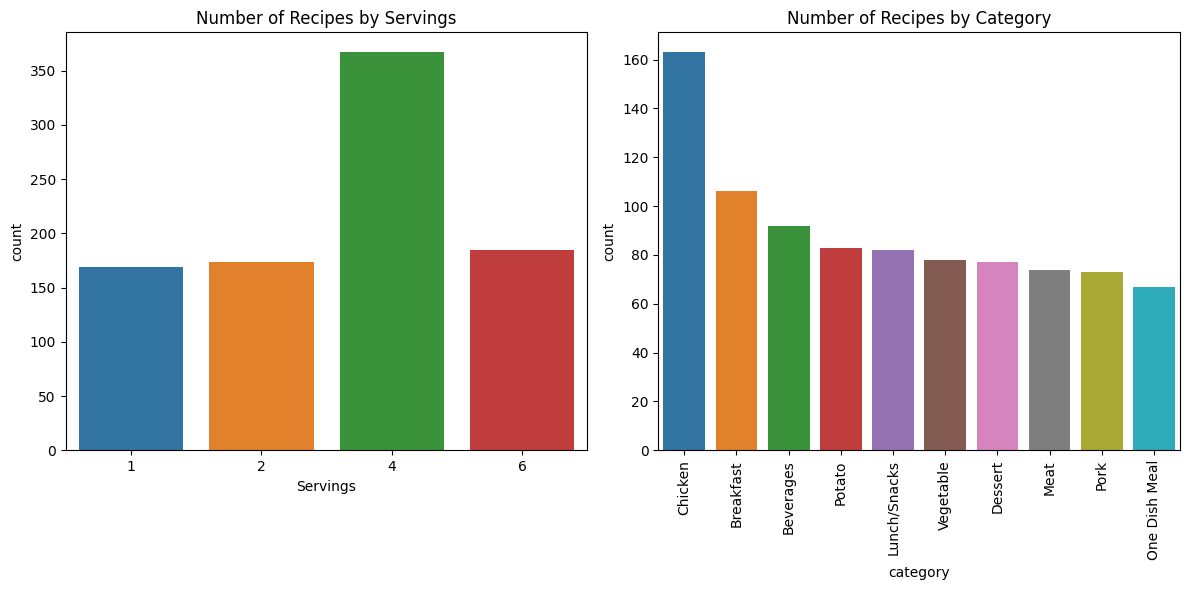

In [397]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

# Countplot for servings
sns.countplot(data=df, x='servings',ax=axes[0])
axes[0].set_title('Number of Recipes by Servings')
axes[0].set_xlabel("Servings")

# Countplot for category (sorted descending)
axes[1].set_title("Number of Recipes by Category")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=90)
sns.countplot(data=df, x="category", ax=axes[1], order=df["category"].value_counts().index)

plt.tight_layout()
plt.show()

The graphs above illustrate the distribution of servings and categories in the dataset.

- Servings: The majority of recipes (approximately 60%) are served for four people, while the number of recipes served for one, two, and six people are almost the same.
- Categories: The most common category in the dataset is chicken, accounting for a significant portion of the recipes.

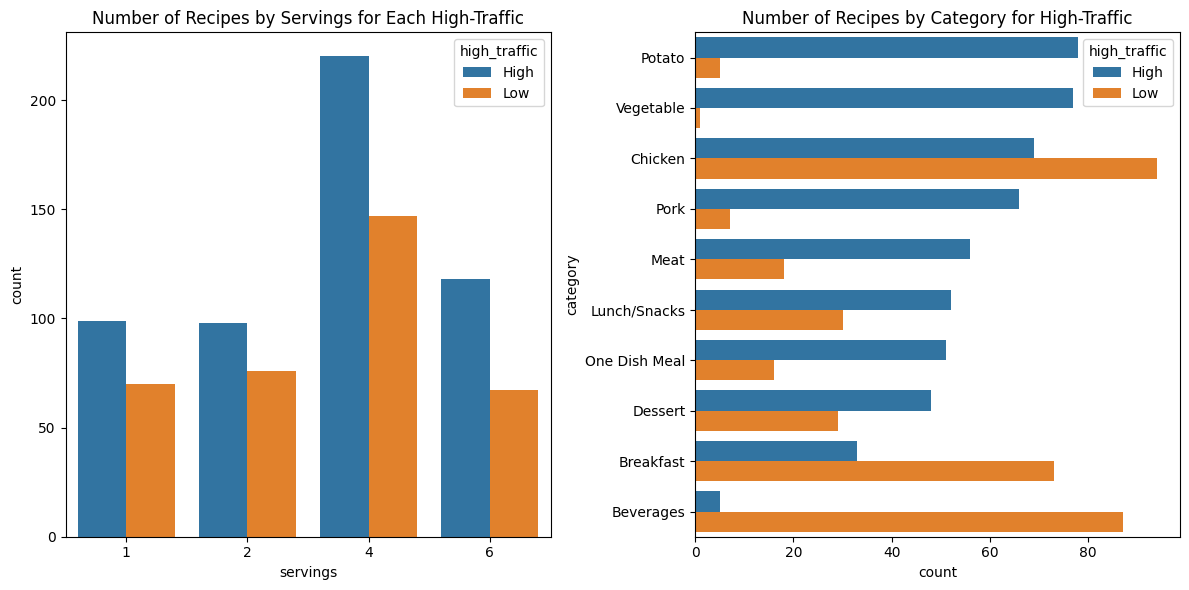

In [398]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Countplot for servings for each high-traffic
axes[0].set_title("Number of Recipes by Servings for Each High-Traffic")
axes[0].set_xlabel("Servings")
axes[0].set_ylabel("Count")
sns.countplot(data=df, x="servings", hue="high_traffic", ax=axes[0])

# Countplot for category for high-traffic (sorted descending)
count = df[df['high_traffic'] == 'High']['category'].value_counts().sort_values(ascending=False)
axes[1].set_title("Number of Recipes by Category for High-Traffic")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Category")
sns.countplot(data=df,hue='high_traffic', y="category", ax=axes[1], order=count.index)
plt.tight_layout()
plt.show()

Two graphs above show us the relationship between the target variables - traffic and two categorical columns: servings and category.
- Traffic vs Servings: For each of servings, the amount of recipes with high traffic is higher than the amount of recipes with low traffic. No significant correlation between servings and high_traffic is seen.
- Traffic vs Category: Except for three categories _(Chicken, Breakfast and Beverages)_, seven categories remain always have the high-traffic recipes higher than the low-traffic recipes. Potato, Vegetable, Pork are the highest in high traffic recipes. The category can influence high-traffic.

## Numerical columns:

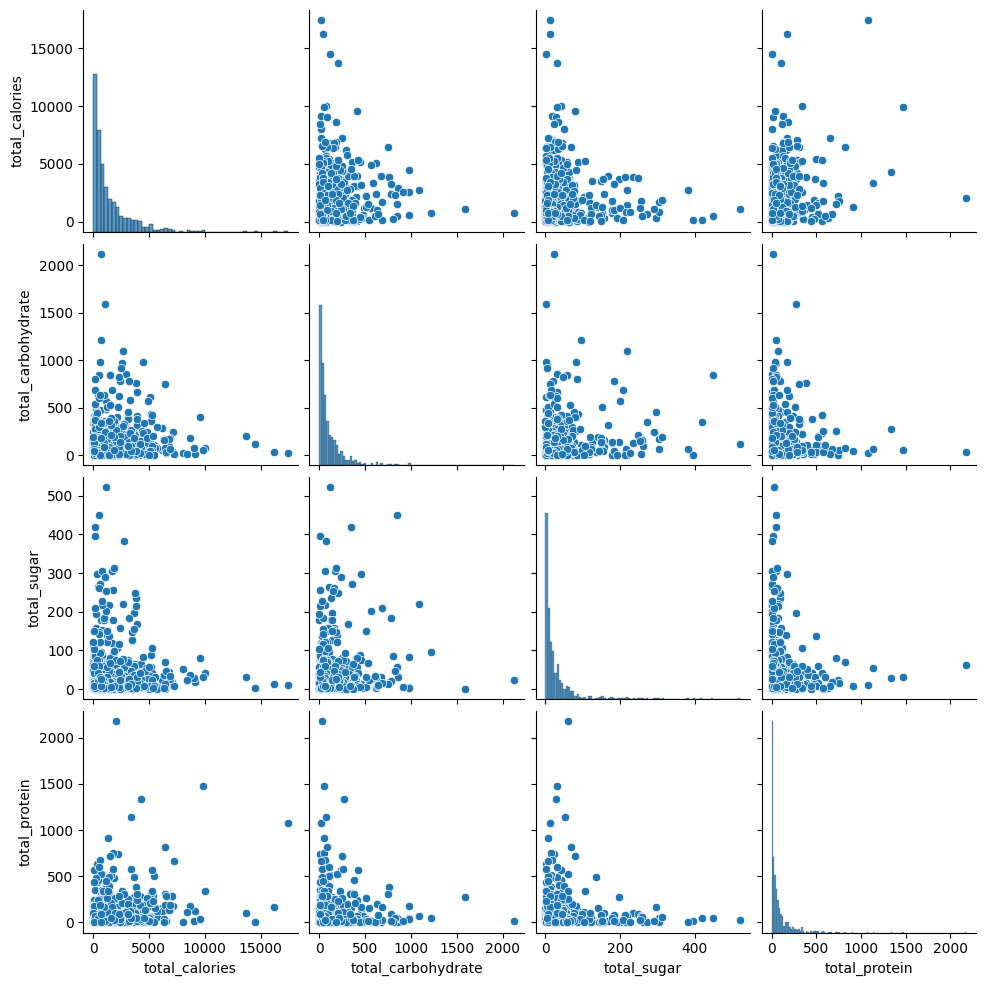

In [399]:
# Pairplot for total calories, total carbohydrate, total sugar, total protein
sns.pairplot(data=df,vars=['total_calories','total_carbohydrate','total_sugar','total_protein'])

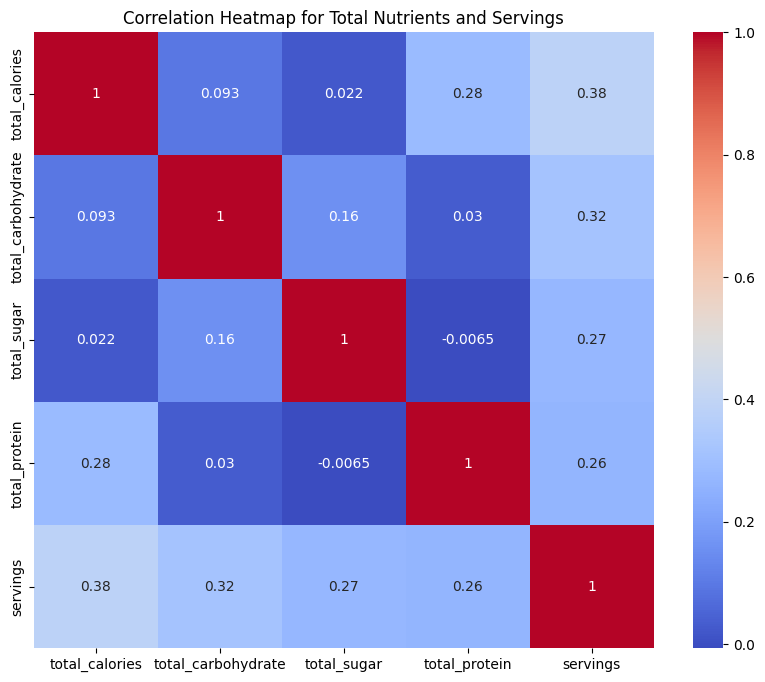

In [400]:
# Heatmap for total calories, total carbohydrate, total sugar, total protein, and servings
plt.figure(figsize=(10, 8))
sns.heatmap(df[["total_calories", "total_carbohydrate", "total_sugar", "total_protein", "servings"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for Total Nutrients and Servings")
plt.show()

From the pairplot and the heatmap, we can see that there is a moderate linear relationship between 5 variables.

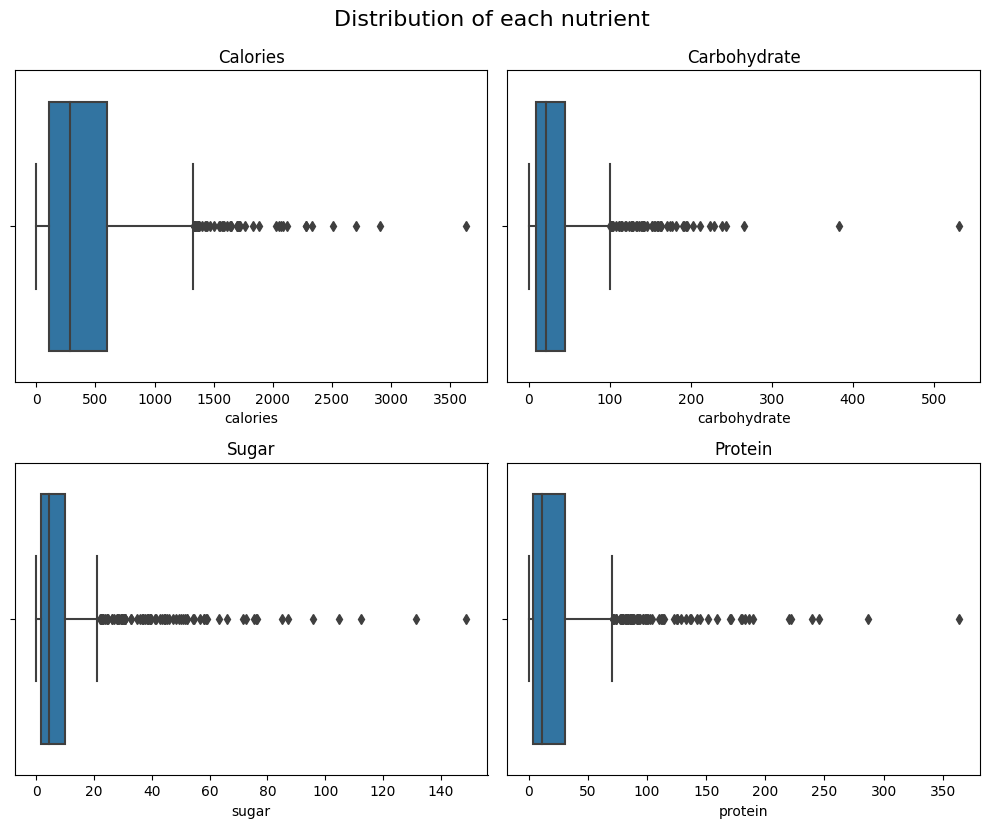

In [401]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Boxplot for calories
sns.boxplot(data=df, x="calories", ax=axes[0, 0])
axes[0, 0].set_title("Calories")

# Boxplot for carbohydrate
sns.boxplot(data=df, x="carbohydrate", ax=axes[0, 1])
axes[0, 1].set_title("Carbohydrate")

# Boxplot for sugar
sns.boxplot(data=df, x="sugar", ax=axes[1, 0])
axes[1, 0].set_title("Sugar")

# Boxplot for protein
sns.boxplot(data=df, x="protein", ax=axes[1, 1])
axes[1, 1].set_title("Protein")

# Adjust the layout and create suptitle
plt.tight_layout()
fig.suptitle('Distribution of each nutrient ',y=1.03,fontsize=16)

# Show the plot
plt.show()

These boxplot let us know that the dataset doesn't have any outliers data.

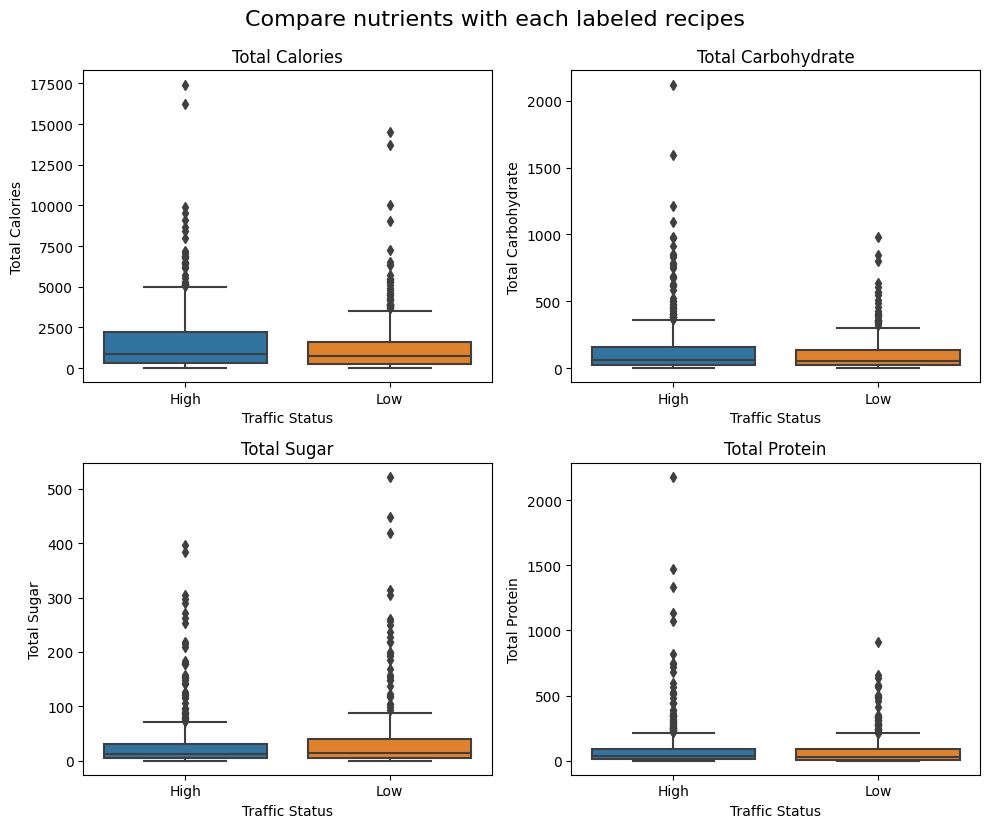

In [402]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Boxplot for total calories
sns.boxplot(x=df['high_traffic'], y=df['total_calories'], ax=axes[0, 0])
axes[0, 0].set_title('Total Calories')
axes[0, 0].set_xlabel('Traffic Status')
axes[0, 0].set_ylabel('Total Calories')

# Boxplot for total carbohydrate
sns.boxplot(x=df['high_traffic'], y=df['total_carbohydrate'], ax=axes[0, 1])
axes[0, 1].set_title('Total Carbohydrate')
axes[0, 1].set_xlabel('Traffic Status')
axes[0, 1].set_ylabel('Total Carbohydrate')

# Boxplot for total sugar
sns.boxplot(x=df['high_traffic'], y=df['total_sugar'], ax=axes[1, 0])
axes[1, 0].set_title('Total Sugar')
axes[1, 0].set_xlabel('Traffic Status')
axes[1, 0].set_ylabel('Total Sugar')

# Boxplot for total protein
sns.boxplot(x=df['high_traffic'], y=df['total_protein'], ax=axes[1, 1])
axes[1, 1].set_title('Total Protein')
axes[1, 1].set_xlabel('Traffic Status')
axes[1, 1].set_ylabel('Total Protein')

# Adjust spacing between subplots and create suptitle
plt.tight_layout()
fig.suptitle('Compare nutrients with each labeled recipes',y=1.03,fontsize=16)

# Show the plot
plt.show()

As we can see from the graph above, there are no major differences in nutrient distribution between the recipe with high-traffic and the recipe with low-traffic.

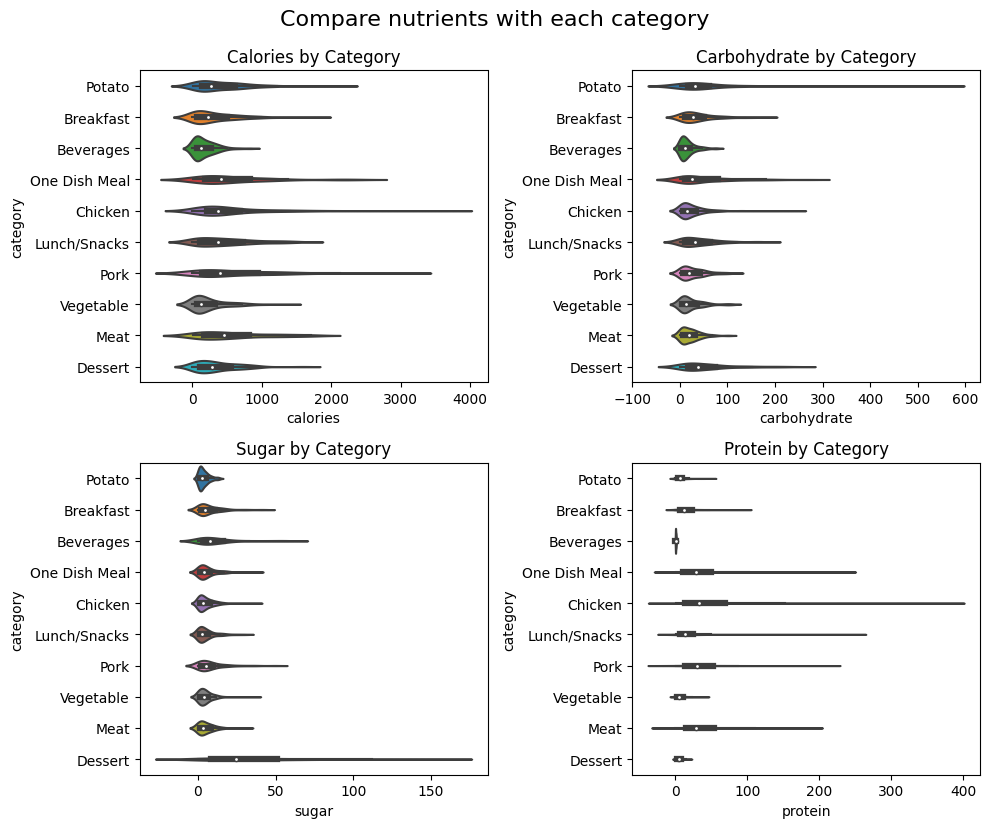

In [403]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Violinplot for calories by category
sns.violinplot(data=df, y="category", x="calories", ax=axes[0, 0])
axes[0, 0].set_title("Calories by Category")

# Violinplot for carbohydrate by category
sns.violinplot(data=df, y="category", x="carbohydrate", ax=axes[0, 1])
axes[0, 1].set_title("Carbohydrate by Category")

# Violinplot for sugar by category
sns.violinplot(data=df, y="category", x="sugar", ax=axes[1, 0])
axes[1, 0].set_title("Sugar by Category")

# Violinplot for protein by category
sns.violinplot(data=df, y="category", x="protein", ax=axes[1, 1])
axes[1, 1].set_title("Protein by Category")

# Adjust the layout and create suptitle
plt.tight_layout()
fig.suptitle('Compare nutrients with each category',y=1.03,fontsize=16)

# Show the plot
plt.show()

- The category that contains the highest level of calories is Chicken then Pork and One Dish Meal.
- The category that contains the highest level of carbohydrate is Potato.
- The category that contains the highest level of sugar is Dessert.
- The category that contains the highest level of protein is Chicken then One Dish Meal, Pork, Lunch/Snacks and Meat.

# Model Development:
Predicting the high traffic is a binary classification problem. I decide to select two models:
1. Baseline model: I choose Logistic Regression (which is a popular and widely used algorithm for binary classification tasks due to its simplicity, interpretability, and effectiveness in many real-world scenarios)
2. Comparison model: I select Linear SVC (which is a type of Support Vector Machine algorithm used for classification tasks)

## Preprocessing model:
Before starting the analysis, I did some preprocessing steps:
1. Convert the values in **high_traffic** to numeric value.
2. Select features and target variables. 
3. Split the data into training set and test set.
4. Normalize the data.
5. Convert categorical columns to numeric columns.

In [404]:
# Replace values in the high-traffic column:
df['high_traffic'] = df['high_traffic'].replace({'High':1,'Low':0})

- Select Features: I choose column **calories, carbohydrate, sugar, protein, category** and **servings** as features.
- Select Target: Because we want to predict the high-traffic recipes therefore I choose **High_traffic** column as the target.
- I split the dataset into 70% of training set and 30% of test set.

In [405]:
feature_num = nutrient + ['servings']
# Features = X
X = df[feature_num + ['category']]

# Target = y
y = df['high_traffic']

In [406]:
# split the data with 30% test size
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=29)

After splitting the data, I did two next preprocessing steps. 
- Normalized the numerical variables in features. 
- Label the category in the features.

In [407]:
# Normalize the data
scaler = StandardScaler()
X_train[feature_num] = scaler.fit_transform(X_train[feature_num])
X_test[feature_num] = scaler.transform(X_test[feature_num])

In [408]:
# Label the category column
encode = LabelEncoder()
X_train['category'] = encode.fit_transform(X_train['category'])
X_test['category'] = encode.transform(X_test['category'])

# The category after label encoder
label_category = dict(zip(encode.classes_,range(len(encode.classes_))))
label_category

{'Beverages': 0,
 'Breakfast': 1,
 'Chicken': 2,
 'Dessert': 3,
 'Lunch/Snacks': 4,
 'Meat': 5,
 'One Dish Meal': 6,
 'Pork': 7,
 'Potato': 8,
 'Vegetable': 9}

## Baseline model: Logistic Regression
- First, I will create a Logistic Regression model, then define the hyperparameter grid.
- Then I use GridSearchCV run with 10 folds to find the optimal hyperparameter.

In [409]:
# Create a Logistic Regression model
lr = LogisticRegression()

# Define hyperparameter grid for Logistic Regression
grid_lr = {'C':np.logspace(-3,3,7),                 
           'penalty':['l1','l2','elasticnet',None],  
           'multi_class':['auto','ovr','multinomial']} 
    
    # C: inverse of regularization strength 
    # penalty: regularization penalty to be used
    # multi_class: strategy for handling multiple classes
    
# Perform GridSearchCV with 10 folds
lr_cv = GridSearchCV(lr, param_grid=grid_lr,cv=10)

# Fit the model with training data
lr_cv.fit(X_train,y_train)

# Print the best parameters:
print('Tuning hyperparameters for Logistic Regression: ',lr_cv.best_params_)

Tuning hyperparameters for Logistic Regression:  {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2'}


- The optimal hyperparameters are: C = 0.001, multi_class = 'multinomial', penalty='l2'.
- I will apply the hyperparameters to the Logistic Regression model and then use that model to predict the output.

In [410]:
# Create a Logistic Regression model with the hyperparameters founded:
lr_tuning = LogisticRegression(C = 0.001, multi_class = 'multinomial', penalty='l2')

# Fit and predict with the model
lr_tuning.fit(X_train,y_train)
y_pred_lr = lr_tuning.predict(X_test)

## Comparison model: Linear SVC
Apply the same workflow as I did for Logistic Regression.

In [411]:
# Create a LinearSVC model
svc = LinearSVC()

# Define hyperparameter grid for LinearSVC
grid_svc = {'C':np.logspace(-3,3,7),                 
           'penalty':['l1','l2'],  
           'loss':['hinge','squared_hinge']} 
    
    # C: inverse of regularization strength 
    # penalty: regularization penalty to be used
    # loss: loss function to be used
    
# Perform GridSearchCV with 10 folds
svc_cv = GridSearchCV(svc, param_grid=grid_svc,cv=10)

# Fit the model with training data
svc_cv.fit(X_train,y_train)

# Print the best parameters:
print('Tuning hyperparameters for LinearSVC: ',svc_cv.best_params_)

Tuning hyperparameters for LinearSVC:  {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}


- The optimal hyperparameters are: C = 0.1, loss = 'hinge', penalty='l2'.
- I will apply the hyperparameters to the LinearSVC model and then use that model to predict the output.

In [412]:
# Create a LinearSVC model with the hyperparameters founded:
svc_tuning = LinearSVC(C = 0.1, loss = 'hinge', penalty='l2')


# Fit and predict with the model
svc_tuning.fit(X_train,y_train)
y_pred_svc = svc_tuning.predict(X_test)

# Model Evaluation:
For this classification problem, I choose three metrics to evaluate the model performance.
- Precision: measures the proportion of correctly predicted positive instances out of the total instances predicted as positive.
- Recall: measures the proportion of correctly predicted positive instances out of the total actual positive instances.
- F1-Score: the harmonic mean of precision and recall. Therefore, gives us a balanced measure of both precision and recall.

Three metrics have range from 0 to 1. The closer to 1, the better.

By considering these metrics, we can better assess the performance of the model in predicting high-traffic recipes accurately.

In [413]:
# Confusion matrix of Logistic Regression:
print('Confusion matrix of Baseline model - Logistic Regression:')
print(confusion_matrix(y_test,y_pred_lr))
print('\n')
# Classification report of Logistic Regression:
print('Classification report of Baseline model - Logistic Regression: ')
print(classification_report(y_test,y_pred_lr))

Confusion matrix of Baseline model - Logistic Regression:
[[ 73  25]
 [ 34 137]]


Classification report of Baseline model - Logistic Regression: 
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        98
           1       0.85      0.80      0.82       171

    accuracy                           0.78       269
   macro avg       0.76      0.77      0.77       269
weighted avg       0.79      0.78      0.78       269



We want to predict the high-traffic recipe (which is labeled as 1 from the replacing step) so we will focus on precision, recall and F1-score of value 1.

The precision, recall and F1-score of Logistic Regression are 0.85, 0.80 and 0.82, respectively.

In [414]:
# Confusion matrix of LinearSVC:
print('Confusion matrix of Comparison model - LinearSVC:')
print(confusion_matrix(y_test,y_pred_svc))
print('\n')
# Classification report of LinearSVC:
print('Classification report of Comparison model - LinearSVC: ')
print(classification_report(y_test,y_pred_svc))

Confusion matrix of Comparison model - LinearSVC:
[[ 75  23]
 [ 41 130]]


Classification report of Comparison model - LinearSVC: 
              precision    recall  f1-score   support

           0       0.65      0.77      0.70        98
           1       0.85      0.76      0.80       171

    accuracy                           0.76       269
   macro avg       0.75      0.76      0.75       269
weighted avg       0.78      0.76      0.77       269



Meanwhile, the precision, recall and F1-score of LinearSVC are 0.85, 0.76 and 0.80, respectively.

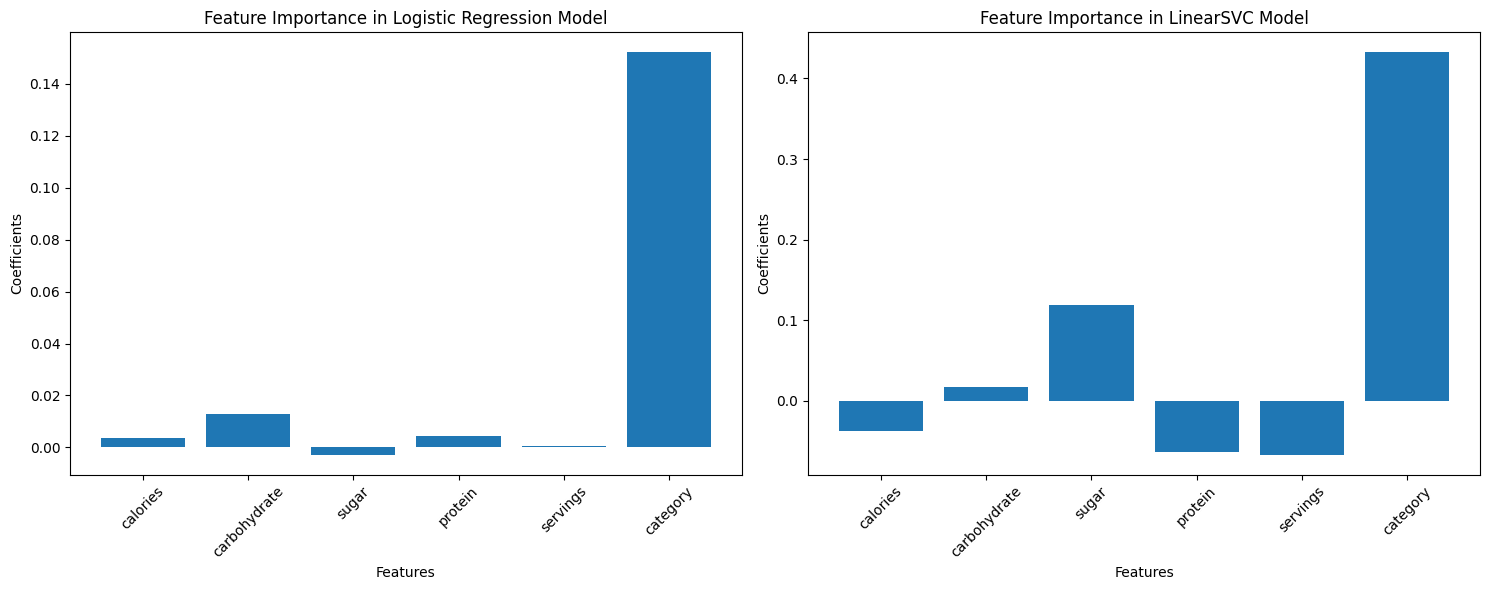

In [415]:
# Get the coefficients and column names
coefficients_lr = lr_tuning.coef_[0]
coefficients_svc = svc_tuning.coef_[0]
columns = X.columns

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the bar chart for Logistic Regression
axs[0].bar(columns, coefficients_lr)
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Coefficients')
axs[0].set_title('Feature Importance in Logistic Regression Model')
axs[0].tick_params(axis='x', rotation=45)

# Plot the bar chart for LinearSVC
axs[1].bar(columns, coefficients_svc)
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Coefficients')
axs[1].set_title('Feature Importance in LinearSVC Model')
axs[1].tick_params(axis='x', rotation=45)

# Display the subplots
plt.tight_layout()
plt.show()

## CONCLUSION:
- Both the Logistic Regression model and LinearSVC model worked well with the dataset. 
- Both models let us know that the category is the most effective feature for the high traffic.
- The precision, recall and F1-score from Logistic Regression model are 0.85, 0.80 and 0.82, respectively, while these metrics from LinearSVC model are 0.85,0.76 and 0.80 respectively.
- Therefore, the Logisic Regression model fits the feature better and gives a lower prediction error than the LinearSVC model.

## Check the predictive model

Now I use the predictive Logistic Regression model to test.
I randomly select a recipe from the test set and use its features as input to the model.

In [416]:
import random
random.seed(24)
random_recipe_index = random.randint(0, len(X_test) - 1)
random_recipe_features = X_test.iloc[random_recipe_index]

# Reshape the features to match the model's input shape
random_recipe_features = random_recipe_features.values.reshape(1, -1)

# Make the prediction using the Logistic Regression model
predicted_traffic = lr_tuning.predict(random_recipe_features)[0]
if predicted_traffic == 1:
    predicted_traffic_category = "High"
else:
    predicted_traffic_category = "Low"

# Get the actual traffic category from the test set
actual_traffic = y_test.iloc[random_recipe_index]
if actual_traffic == 1:
    actual_traffic_category = "High"
else:
    actual_traffic_category = "Low"

# Print the results
print("Predicted Traffic Category: ", predicted_traffic_category)
print("Actual Traffic Category: ", actual_traffic_category)

Predicted Traffic Category:  High
Actual Traffic Category:  High


Great !!! the predicted value and the actual value are the same.

## Business Focus:
There are two primary business goals for this project:
1. Predict which recipes will have high-traffic.
2. Predict the recipes high-traffic with at least 80% probability.

**CONCLUSION:** 

According to the results from the above steps, the Logistic Regression satisfied both business goals. Its precision, recall and F1-score have values equal to or greater than 80%.

# Business Metrics:
The Tasty Bytes wants to increase the accuracy of predicting high-traffic.

Therefore, we would consider using the accuracy of predictions that predicted high traffic as a KPI to compare two models performance with the business criteria. The model that has a higher accuracy score will perform better.

In [417]:
# Accuracy score of Logistic Regression:
test_accuracy_lr = accuracy_score(y_test,y_pred_lr)

# Accuracy score of LinearSVC:
test_accuracy_svc = accuracy_score(y_test, y_pred_svc)

print("Accuracy score when using Logistic Regression: ", test_accuracy_lr)
print("Accuracy score when using Linear SVC: ", test_accuracy_svc)

Accuracy score when using Logistic Regression:  0.7806691449814126
Accuracy score when using Linear SVC:  0.7620817843866171


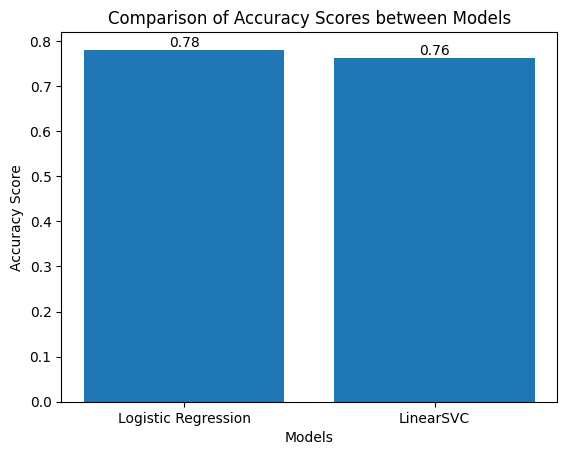

In [418]:
# Bar graph
models = ['Logistic Regression', 'LinearSVC']
accuracy_scores = [test_accuracy_lr, test_accuracy_svc]

plt.bar(models, accuracy_scores)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')

# Add value labels to the bars
for i, v in enumerate(accuracy_scores):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.title('Comparison of Accuracy Scores between Models')
plt.show()

**CONCLUSION:**

Upon evaluation, the Logistic Regression model achieved an accuracy of 78%, while the Linear SVC model had a slightly lower accuracy of 76%. 

# FINAL SUMMARY:
The Logistic Regression model outperforms the Linear SVC model in terms of accurately predicting high-traffic recipes.

## Recommendations for future action:
- We suggest to deploy the Logistic Regression model to the recent recipes. With approximately 78% in predict high-traffic recipes, this predictive model can assist the product manager reaches the business goals in generating more traffic to the websit and boost overall performances.

- Both models suggest that category is the main feature affecting the traffic. Therefore, we should try to increase the number of categories and create more meaningful features from existing variables.
 
- To improve the accuracy, we should collect more information, such as more details about time to cost, cost per servings, and also the combination of ingredients.

By implementing these recommendations, combined with the iterative improvement of the model and continous data collection, the product manager can benefit from a more accurate and effective predictive model, leading to better insights into recipe performance and website traffic.